# Zero-Shot Object Detection with OWL-ViT Model

This tutorial shows how to implement Zero-Shot Object Detection with the [OWL-ViT](https://huggingface.co/docs/transformers/model_doc/owlvit) model.

## Object detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects, each with its own bounding box and a label (e.g. it can have a car and a building), and each object can be present in different parts of an image (e.g. the image can have several cars). This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights. Other applications include counting objects in images, image search, and more.

### Use Cases

1. Autonomous Driving: Object Detection is widely used in computer vision for autonomous driving. Self-driving cars use Object Detection models to detect pedestrians, bicycles, traffic lights and road signs to decide which step to take.
1. Object Tracking in Sport Matches: Object Detection models are widely used in sports where the ball or a player is tracked for monitoring and refereeing during matches.
1. Image Search: Object Detection models are widely used in image search. Smartphones use Object Detection models to detect entities (such as specific places or objects) and allow the user to search for the entity on the Internet.
1. Object Counting: Object Detection models are used to count instances of objects in a given image, this can include counting the objects in warehouses or stores, or counting the number of visitors in a store. They are also used to manage crowds at events to prevent disasters.

## Zero-shot object detection

Traditionally, models used for object detection require labeled image datasets for training, and are limited to detecting the set of classes from the training data. Zero-shot object detection (ZSD) is the task of object detection where no visual training data is available for some of the target object classes.

## The OWL-ViT model

In this notebook we approach the problem of Zero-shot object detection with the [OWL-ViT](https://huggingface.co/docs/transformers/model_doc/owlvit) model. The OWL-ViT (short for Vision Transformer for Open-World Localization) model was proposed in [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) by Matthias Minderer, Alexey Gritsenko, Austin Stone, Maxim Neumann, Dirk Weissenborn, Alexey Dosovitskiy, Aravindh Mahendran, Anurag Arnab, Mostafa Dehghani, Zhuoran Shen, Xiao Wang, Xiaohua Zhai, Thomas Kipf, and Neil Houlsby. OWL-ViT is an open-vocabulary object detection network trained on a variety of (image, text) pairs. This means that it can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets.

OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) as its multi-modal backbone with a ViT-like Transformer to get visual features and a causal language model to get the text features. Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads, associate images and their corresponding textual descriptions, and ViT processes image patches as inputs. The authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using a bipartite matching loss. To use CLIP for detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

With this approach, the model can detect objects based on textual descriptions without prior training on labeled datasets.

In this guide, we will learn how to use OWL-ViT:
1. to detect objects based on text prompts
1. for batch object detection
1. for image-guided object detection

Before we begin, we'll make sure we have all the necessary libraries installed:

In [ ]:
pip install --upgrade transformers

## Define some variables

In [19]:
MODEL_CHECKPOINT = "google/owlvit-base-patch32" # Pre-trained model

TEST_IMAGE_URL = "https://unsplash.com/photos/oeSNkrUuhQU/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTc5fHxwaWNuaWN8ZW58MHx8fHwxNjk2NTg3Mjc0fDI&force=true&w=640"

## Load the model

We start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?other=owlvit).

In [7]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(MODEL_CHECKPOINT)
processor = AutoProcessor.from_pretrained(MODEL_CHECKPOINT)

Next, we load an image we’d like to detect objects in. 

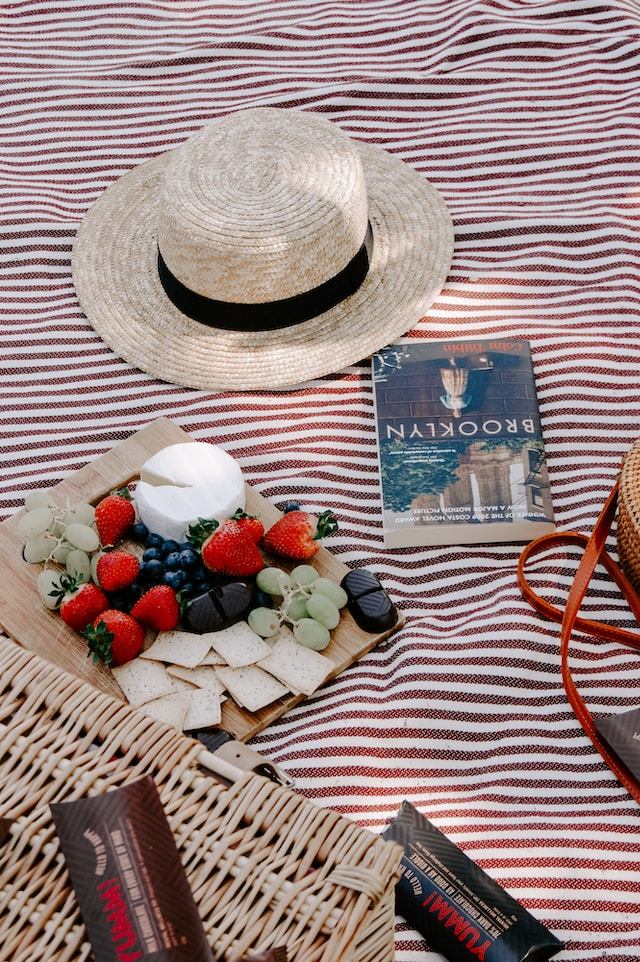

In [20]:
import requests
from PIL import Image

im = Image.open(requests.get(TEST_IMAGE_URL, stream=True).raw)
im

We now use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the image for the model by resizing and normalizing it, and a [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.34.0/en/model_doc/clip#transformers.CLIPTokenizer) that takes care of the text inputs.

In [23]:
text_queries = ["hat", "book", "grapes", "strawberry"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

Now, we pass the inputs through the model, post-process, and visualize the results. Since the image processor resized images before feeding them to the model, we need to use the `post_process_object_detection()` method to make sure the predicted bounding boxes have the correct coordinates relative to the original image:

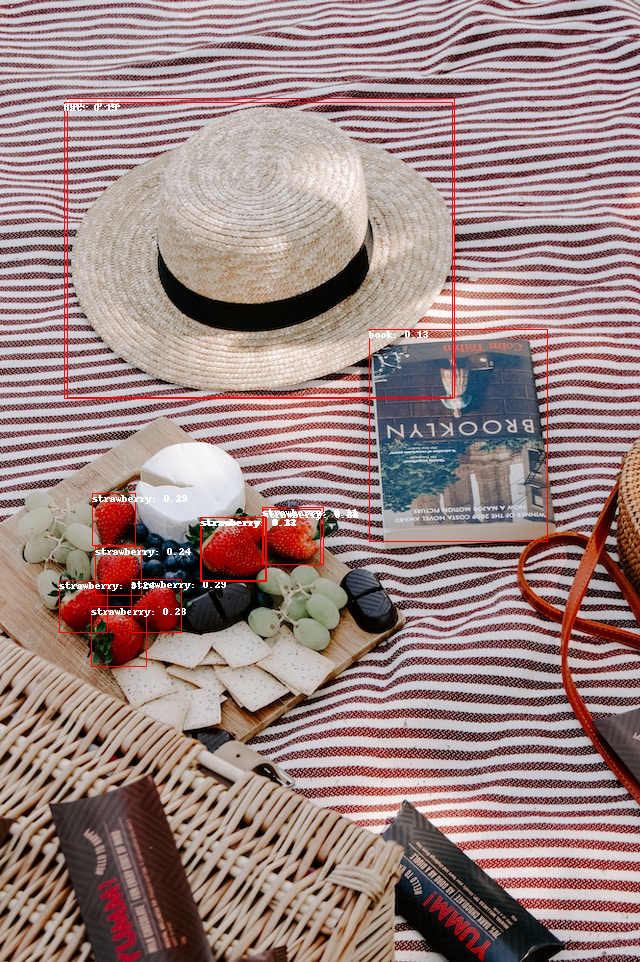

In [24]:
import torch
from PIL import ImageDraw

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im